# Text Classification of Movie Plots to Predict Movie Genre

# Business Understanding

Movies are a popular means of entertainment all around the world. With a lot of streaming services and websites available and with more on the horizon, building a predictive model that automatically generates the genre of a movie based on the its plot summary is definitely beneficial as it may reduce the expense of manually tagging the movies.

# Data Understanding

The dataset used in this notebook was obtained from kaggle and it contains movie plot summaries scraped from wikipedia. The dataset has 34,886 entries.Information found in the datasetis as follows:

1. Release Year - year of release
2. Title - title of the movies
3. Origin/Ethnicity - country of origin of the movies
4. Director - director names associated with the movies
5. Cast - cast name associated with the movies
6. Wiki Page - wikipedia page of the movies
7. Plot - plot summary of the movies

# Data Exploration 

## Import necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
import seaborn as sns
# from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix
warnings.filterwarnings('ignore')
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.text import FreqDistVisualizer
import dataframe_image as dfi
from mlxtend.feature_selection import ColumnSelector

## Read data into pandas

In [2]:
wiki= pd.read_csv('./data/wiki_movie_plots_deduped.csv')

wiki.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Descriptive Statistics

### The release years range from 1901 to 2017 in the dataset

In [3]:
wiki.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


### There are 34886 rows and 8 columns 

In [4]:
wiki.shape

(34886, 8)

In [5]:
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


# Exploratory Data Analysis

## Movie Distributions by Release Year

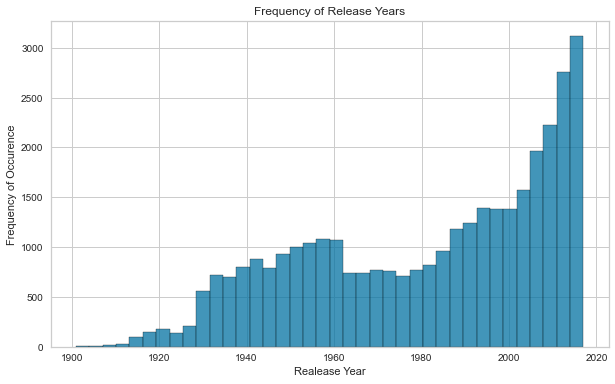

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x = wiki['Release Year'])
plt.title('Frequency of Release Years')
plt.xlabel('Realease Year')
plt.ylabel('Frequency of Occurence')
fig.savefig('./images/freqofreleaseyear.png');

## Movie distribution by Movie Origin

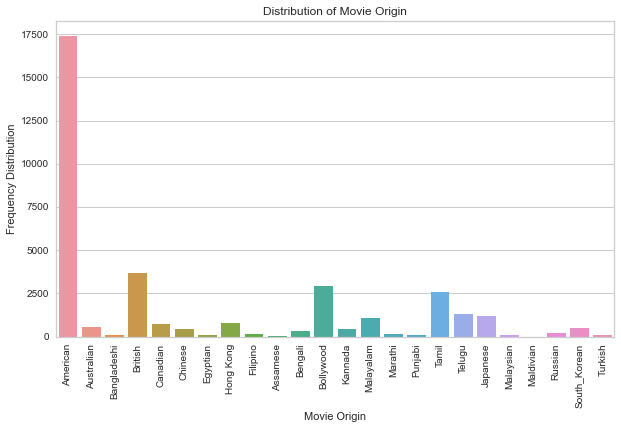

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

sns.countplot(x = wiki['Origin/Ethnicity'])
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('Distribution of Movie Origin')
plt.xlabel('Movie Origin')
plt.ylabel('Frequency Distribution')
fig.savefig('./images/FreqDistOrigin.png');

## Subsetting the dataset to include only the entries with a known genre and resetting the index

In [8]:
wiki_df = wiki.loc[wiki['Genre']!='unknown']
wiki_df.reset_index(drop = True, inplace = True)

Checking the number of unique values we have in the genres column

In [9]:
genres=pd.value_counts(wiki_df.Genre)

print('There are ',len(genres), 'different Genres in the dataset:')
print('-'*50)
print(genres)

There are  2264 different Genres in the dataset:
--------------------------------------------------
drama                                 5964
comedy                                4379
horror                                1167
action                                1098
thriller                               966
                                      ... 
adventure, comedy, fantasy               1
warner bros. biography                   1
action, adventure, fantasy, comedy       1
concert, documentary                     1
teen, comedy                             1
Name: Genre, Length: 2264, dtype: int64


## Getting the top 6 most commonly occuring genres in the dataset

In [10]:
top_genres = pd.DataFrame(genres[:6]).reset_index()
top_genres.columns = ['genres', 'number_of_movies']
top_genres

,genres,number_of_movies
0,drama,5964
1,comedy,4379
2,horror,1167
3,action,1098
4,thriller,966
5,romance,923


## Movie distribution of the top six genres in the dataset

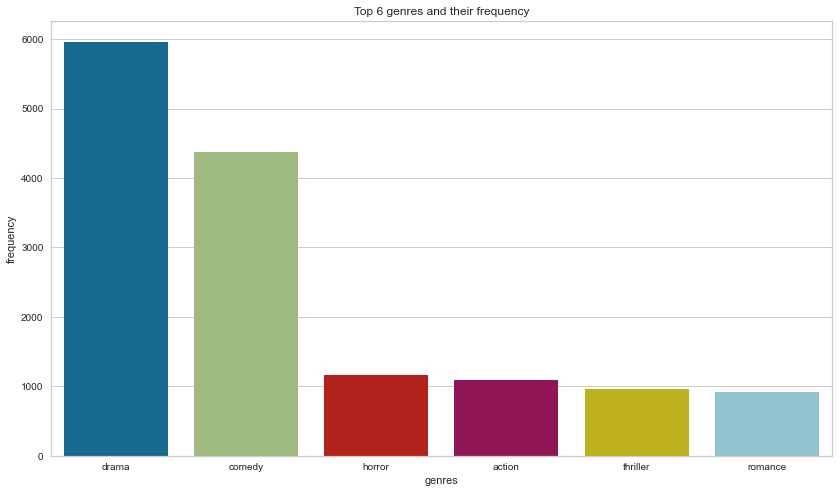

In [11]:
fig, ax = plt.subplots(figsize=(14,8))

sns.barplot(top_genres['genres'], top_genres['number_of_movies'])
plt.title('Top 6 genres and their frequency')
plt.xlabel('genres')
plt.ylabel('frequency')
fig.savefig('./images/freqoftopgenres.png')

## Creating separate labels column for the top 6 genres only and assigning the values between 1-6 for drama, comedy,horror, action, thriller and romance, respectively if present in the genre column of the movie (for entries that have only one genre)

In [12]:
conditions = [wiki_df['Genre']=='drama', wiki_df['Genre']=='comedy', wiki_df['Genre']=='horror', wiki_df['Genre']=='action', wiki_df['Genre']=='thriller',
             wiki_df['Genre']=='romance']
choices = [1,2,3,4,5,6]
wiki_df['labels'] = np.select(conditions, choices, 0)

In [13]:
wiki_df.sample(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
7471,1961,The Wizard of Baghdad,American,George Sherman,"Dick Shawn, Diane Baker",comedy,https://en.wikipedia.org/wiki/The_Wizard_of_Ba...,A genie turned mortal after his many failures ...,2
7752,1964,The Fall of the Roman Empire,American,Anthony Mann,"Sophia Loren, James Mason, Stephen Boyd, Chris...",epic,https://en.wikipedia.org/wiki/The_Fall_of_the_...,"In the winter of 180 A.D., the Roman emperor M...",0
18078,1942,Talk About Jacqueline,British,"Harold French, Paul L. Stein","Hugh Williams, Carla Lehmann",comedy,https://en.wikipedia.org/wiki/Talk_About_Jacqu...,"A drama about two sisters, Jacqueline and June...",2


In [14]:
wiki_df['labels'].value_counts()

0    14306
1     5964
2     4379
3     1167
4     1098
5      966
6      923
Name: labels, dtype: int64

## Subsetting the wiki_df dataframe to only include the rows that have entries (1-6) in the newly created labels columns (the ones that have only a single genre entry)

In [15]:
 df_to_use = (wiki_df.loc[wiki_df['labels']!=0]).reset_index(drop = True)

In [16]:
# We are now left with about 14 thousand rows of data
df_to_use.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,2
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,2
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,2
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,1
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,1


## Table showing Genre label assignments

In [17]:
assigned_label = pd.DataFrame(sorted(list(zip(df_to_use['Genre'].unique(), df_to_use['labels'].unique())), key = lambda x : x[1], reverse = False), columns = ['genres', 'labels'])
pd.merge(assigned_label, top_genres)

,genres,labels,number_of_movies
0,drama,1,5964
1,comedy,2,4379
2,horror,3,1167
3,action,4,1098
4,thriller,5,966
5,romance,6,923


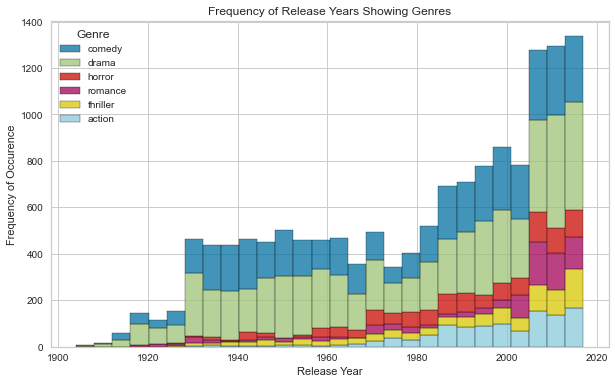

In [18]:
# df_to_use.groupby(['Release Year', 'Genre']).agg('count')
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x = 'Release Year', hue = 'Genre', data = df_to_use, multiple = 'stack')
plt.title('Frequency of Release Years Showing Genres')
plt.xlabel('Release Year')
plt.ylabel('Frequency of Occurence')
fig.savefig('./images/freqofreleaseyearandgenres.png');

## Dropping unnecessary columns

In [19]:
df_to_use.drop(columns = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis = 1, inplace = True)

In [20]:
df_to_use.head(2)

,Title,Genre,Plot,labels
0,The Suburbanite,comedy,The film is about a family who move to the sub...,2
1,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...,2


In [21]:
df_to_use.describe()

,labels
count,14497.000000
mean,2.275160
std,1.528956
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


## Cleaning up the 'Plot' column for Analysis

Below we are just looking at a sample of the plot summary

In [22]:
df_to_use['Plot'][5]

"A young couple decides to elope after being caught in the midst of a romantic moment by the woman's angry father. They make plans to leave, but a thief discovers their plans and hides in their trunk and waits for the right moment to steal their belongings."

### Total number of words in the Plot summaries

In [23]:
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

raw_length = word_length(df_to_use['Plot'])

### Total number of UNIQUE words in the plot summaries

In [24]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

raw_unique_length = unique_word_length(df_to_use['Plot'])

### Creating our stopwords list and adding some more words that are very common in the summaries. (I ran the freqdist after this and noticed that some of these words were very common but didn't lend us too much meaning so I came back here to add them to the stopwords list). Changing the text to lower case, stopwords removal, lemmatizing.

In [97]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 
stopwords_list += [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = ' '.join(text)
    text = nlp(text)
    text = [w.lemma_ for w in text]
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

Rechecking the summary we looked at above to see if our function worked

In [98]:
new_df = df_to_use.copy(deep = True)

In [99]:
new_df['Plot'] = new_df['Plot'].map(lambda x : clean_text(x))
new_df['Plot'][5]

'young couple decide elope catch midst romantic moment woman angry father make plan leave thief discover plan hide trunk wait right moment steal belonging'

In [100]:
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

clean_length = word_length(new_df['Plot'])

In [101]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

clean_unique_length = unique_word_length(new_df['Plot'])

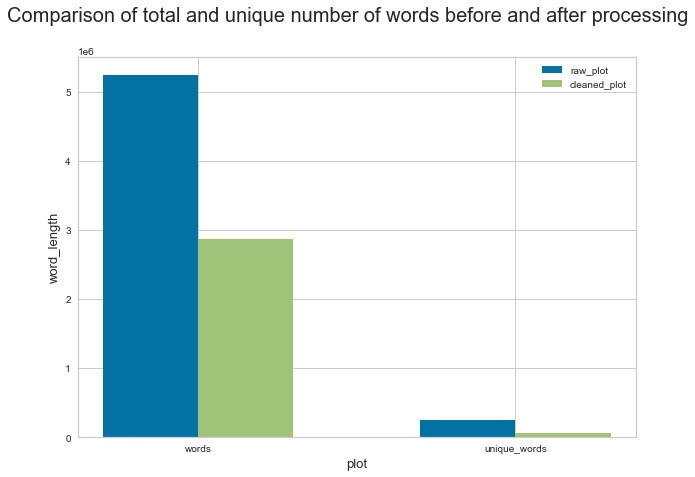

In [102]:
plot_length = [[raw_length, clean_length], [raw_unique_length, clean_unique_length]]
length_df = pd.DataFrame(plot_length, columns = ['num_of_words', 'num_of_unique_words'])
length_df['index'] = ['raw_plot', 'cleaned_plot']

y1 = length_df['num_of_words']
y2 = length_df['num_of_unique_words']

plt.figure(figsize=(10,7))
ind = np.arange(2)

width = 0.3       

# Plotting
plt.bar(ind, y1, width, label='raw_plot')
plt.bar(ind + width, y2, width, label='cleaned_plot')

plt.xlabel('plot', size = 13)
plt.ylabel('word_length', size = 13)
plt.suptitle('Comparison of total and unique number of words before and after processing', size = 20)
plt.xticks(ind + width / 2, ('words', 'unique_words'))
plt.legend(loc='best')
plt.show()
fig.savefig('./images/totalvsuniquewords.png')

In [103]:
length_df

,num_of_words,num_of_unique_words,index
0,5240143,2867928,raw_plot
1,253147,69234,cleaned_plot


## More EDA

### Distribution of words in plot and movie title for each genre

DRAMA

Frequency Distribution plot showing the 20 most common words in the plot summaries in drama

We can see from the plot that the most common words have to do with family, life, love, etc 

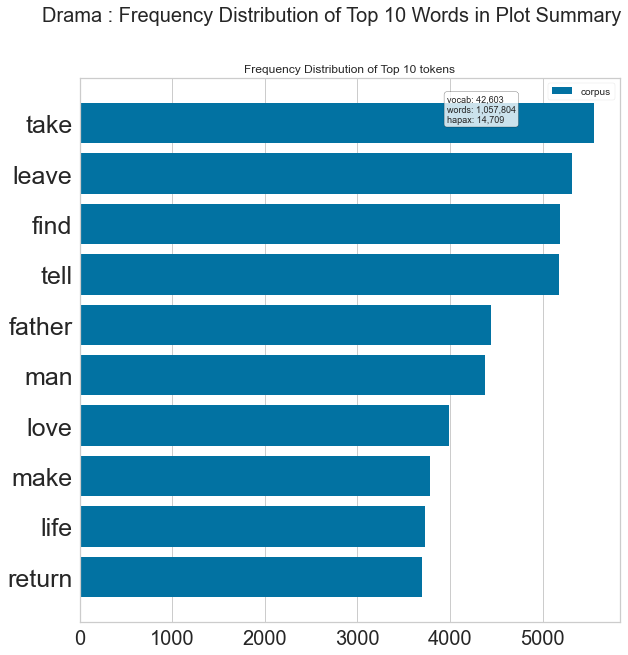

In [104]:
drama_plot = new_df.loc[new_df['labels'] == 1, ['Plot', 'Title']]
drama_plotlist = [x for x in drama_plot['Plot'].str.split()]
drama_plotlist = list(itertools.chain(*drama_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(drama_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Drama : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryfordramagenre.png');

The wordcloud below shows the 20 most frequent words in drama

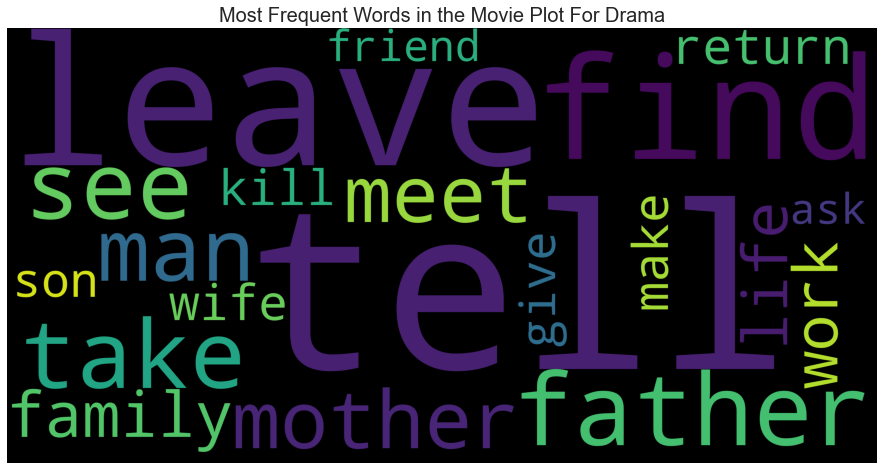

In [51]:
plot_corpus = ' '.join(drama_plot_joined)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words = 20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Drama', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudDrama.png');

A worldcloud showing the most frequent words in movie titles for drama

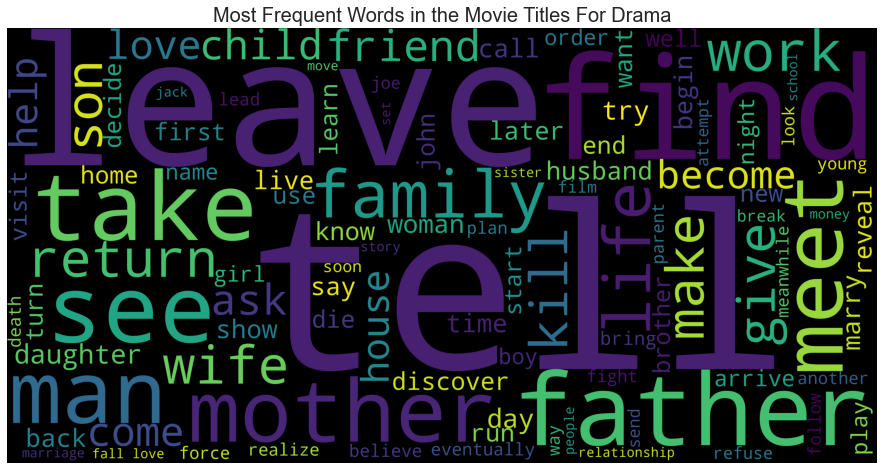

In [52]:
title_corpus = ' '.join(drama_plot_joined)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Drama', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudDrama.png');

COMEDY

Frequency Distribution plot showing the 20 most common words in the plot summaries in comedy

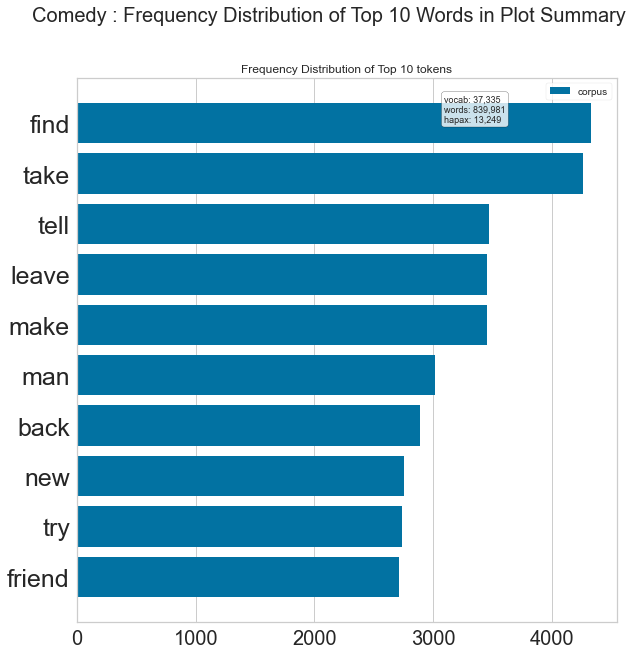

In [105]:
comedy_plot = new_df.loc[new_df['labels'] == 2, ['Plot', 'Title']]
comedy_plotlist = [x for x in comedy_plot['Plot'].str.split()]
comedy_plotlist = list(itertools.chain(*comedy_plotlist))


count = CountVectorizer()
docs       = count.fit_transform(comedy_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Comedy : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforcomedygenre.png');

The wordcloud below shows the 20 most frequent words above for comedy

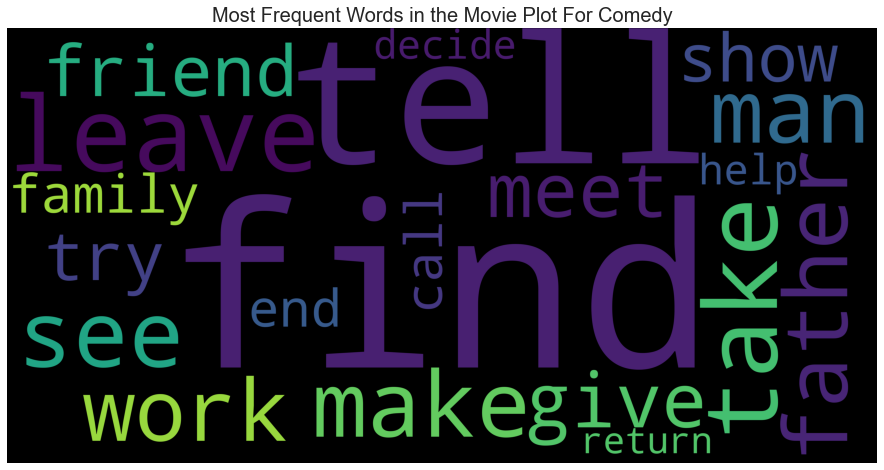

In [57]:
plot_corpus = ' '.join(comedy_plotlist)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words = 20, height=2000, width=4000, random_state = 42, 
                          normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Comedy', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudComedy.png');

A worldcloud showing the most frequent words in movie titles for comedy

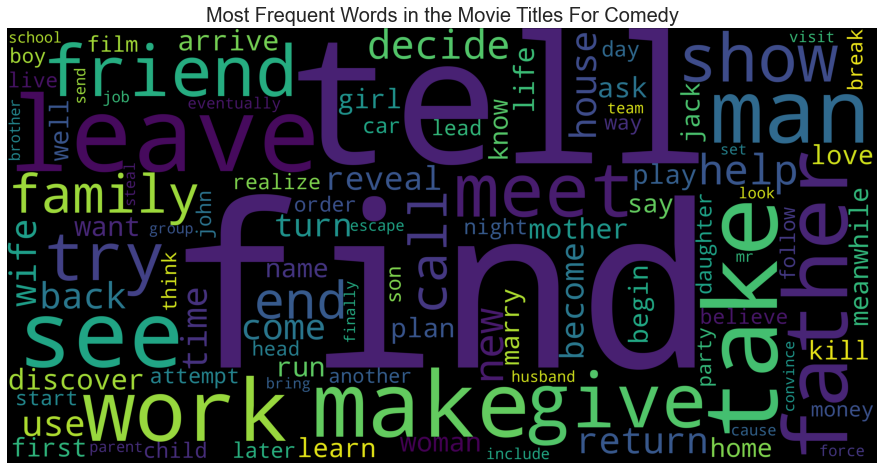

In [58]:
title_corpus = ' '.join(comedy_plotlist)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Comedy', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudComedy.png');

HORROR

Frequency Distribution plot showing the 20 most common words in the plot summaries in horror. Words like kill, deadly and body appear to be very common

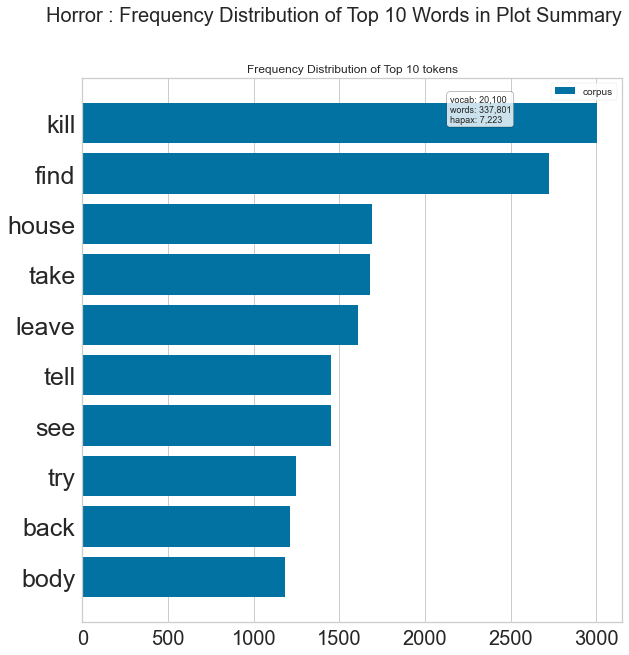

In [106]:
horror_plot = new_df.loc[new_df['labels'] == 3, ['Plot','Title']]
horror_plotlist = [x for x in horror_plot['Plot'].str.split()]
horror_plotlist = list(itertools.chain(*horror_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(horror_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Horror : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforhorrorgenre.png');

The wordcloud below shows the same thing above for horror

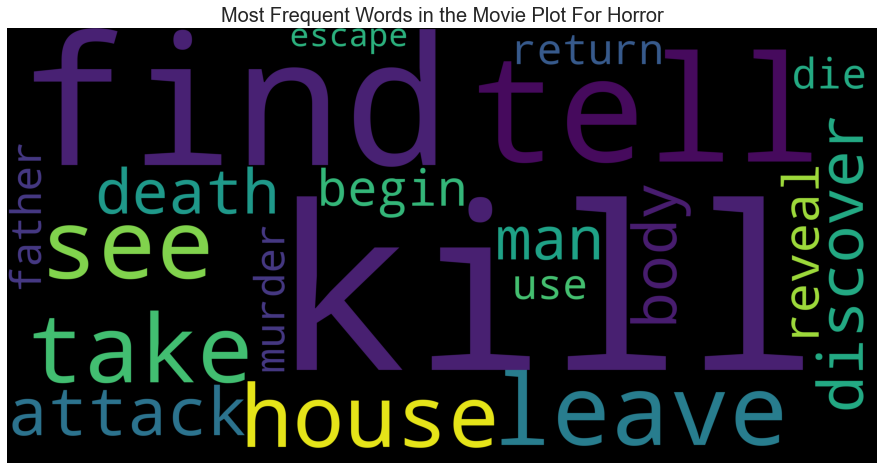

In [60]:
plot_corpus = ' '.join(horror_plot_joined)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Horror', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudHorror.png');

A worldcloud showing the most frequent words in movie titles for horror

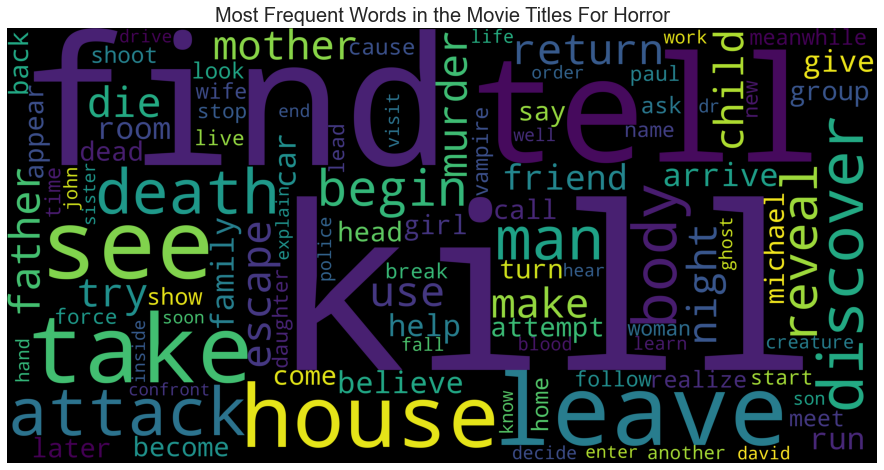

In [61]:
title_corpus = ' '.join(horror_plot_joined)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Horror', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudHorror.png');

ACTION

Frequency Distribution plot showing the 20 most common words in the plot summaries in action

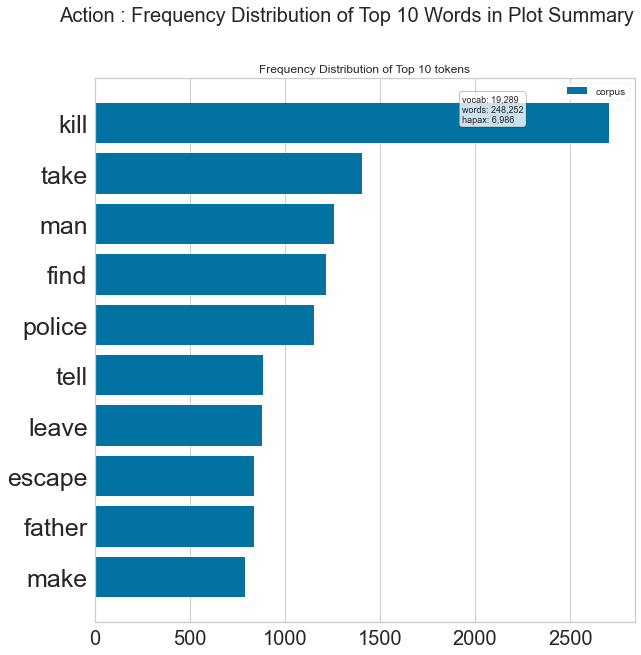

In [107]:
action_plot = new_df.loc[new_df['labels'] == 4, ['Plot', 'Title']]
action_plotlist = [x for x in action_plot['Plot'].str.split()]
action_plotlist = list(itertools.chain(*action_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(action_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Action : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforactiongenre.png');

The wordcloud below shows the same thing above for action

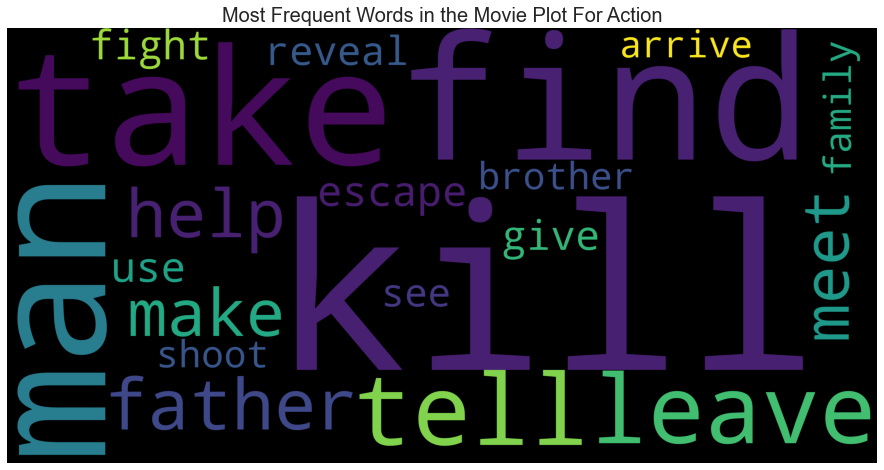

In [63]:
plot_corpus = ' '.join(action_plotlist)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Action', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudAction.png');

A worldcloud showing the most frequent words in movie titles for action

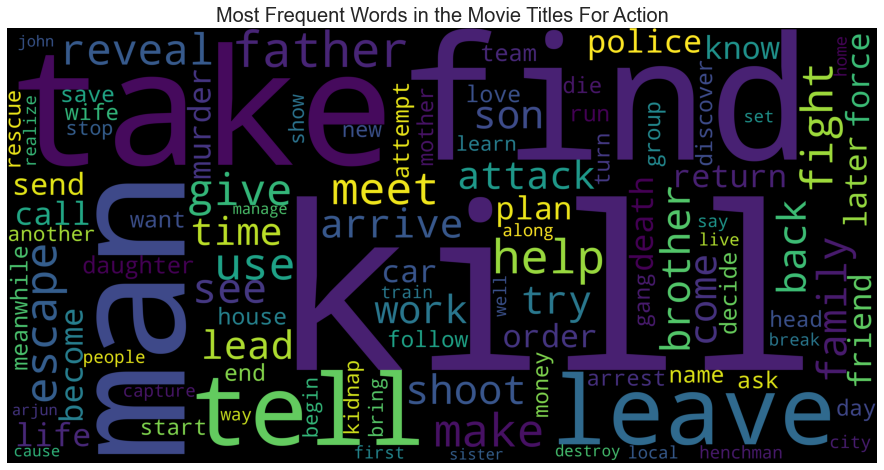

In [64]:
title_corpus = ' '.join(action_plotlist)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Action', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudAction.png');

THRILLER

Frequency Distribution plot showing the 20 most common words in the plot summaries in thriller

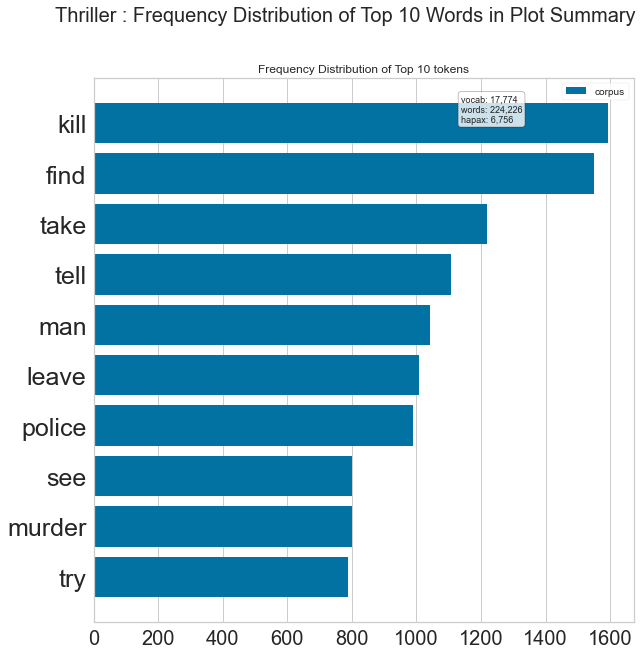

In [108]:
thriller_plot = new_df.loc[new_df['labels'] == 5, ['Plot', 'Title']]
thriller_plotlist = [x for x in thriller_plot['Plot'].str.split()]
thriller_plotlist = list(itertools.chain(*thriller_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(thriller_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Thriller : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforthrillergenre.png');

The wordcloud below shows the same thing above for thriller

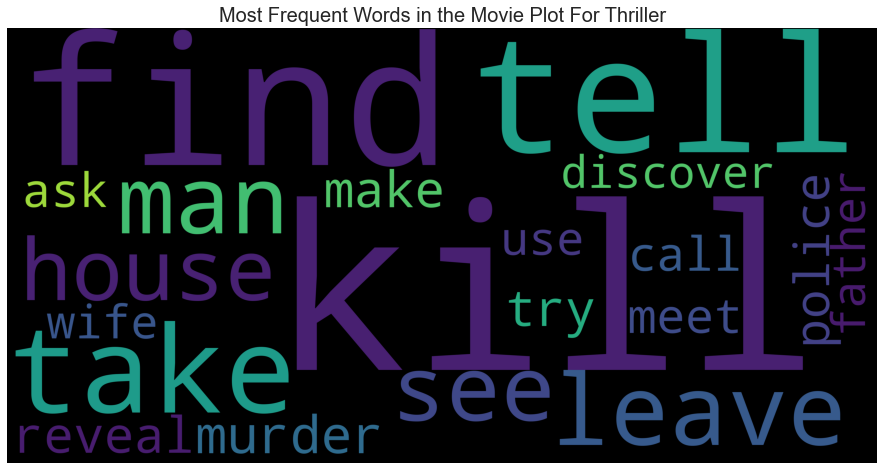

In [66]:
plot_corpus = ' '.join(thriller_plotlist)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Thriller', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudThriller.png');

A worldcloud showing the most frequent words in movie titles for thriller

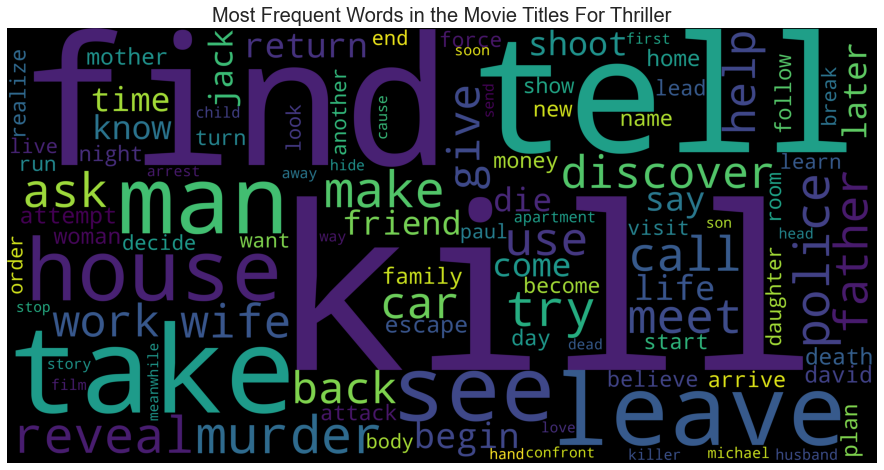

In [67]:
title_corpus = ' '.join(thriller_plotlist)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Thriller', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudThriller.png');

ROMANCE

Frequency Distribution plot showing the 20 most common words in the plot summaries in romance

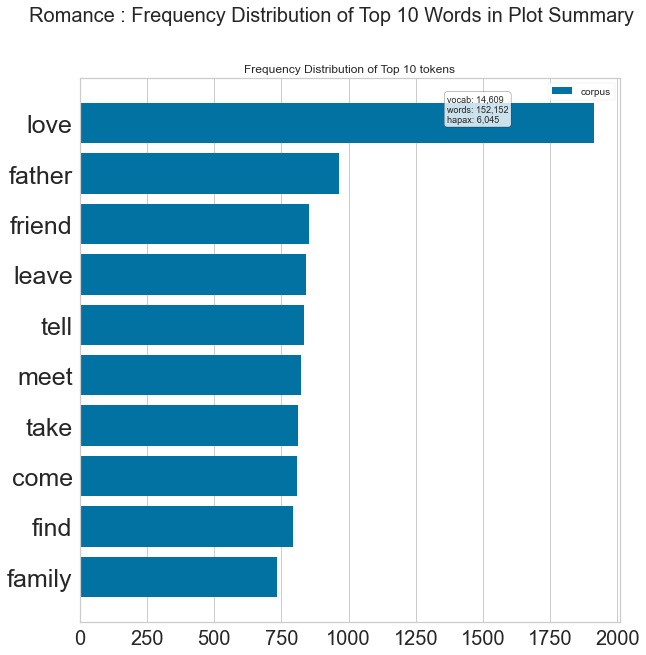

In [109]:
romance_plot = new_df.loc[new_df['labels'] == 6, ['Plot', 'Title']]
romance_plotlist = [x for x in romance_plot['Plot'].str.split()]
romance_plotlist = list(itertools.chain(*romance_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(romance_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Romance : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforromancegenre.png');

The wordcloud below shows the same thing above for romance

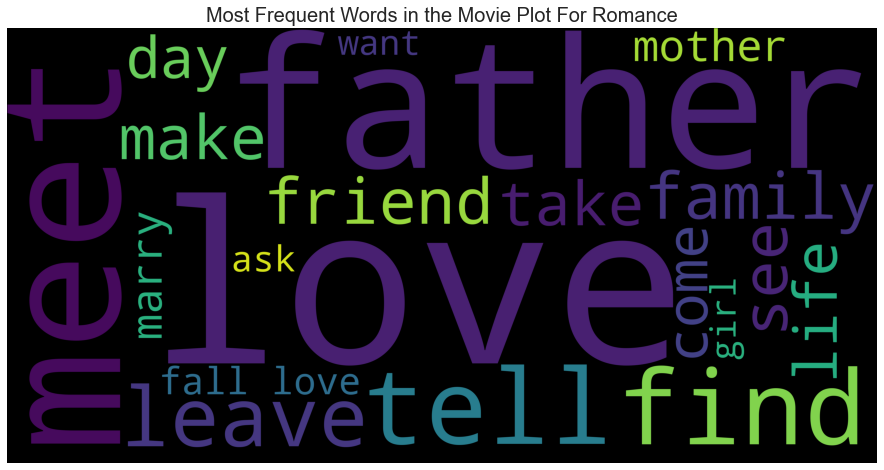

In [69]:
plot_corpus = ' '.join(romance_plotlist)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Romance', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudRomance.png');

A worldcloud showing the most frequent words in movie titles for romance

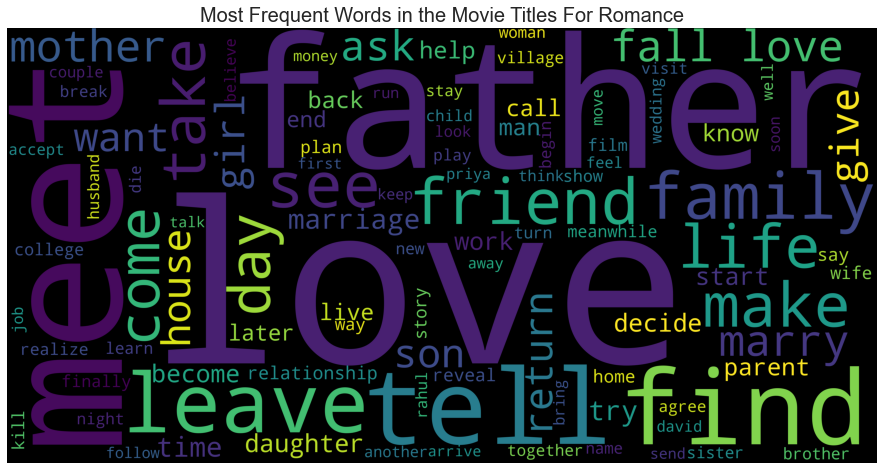

In [70]:
title_corpus = ' '.join(romance_plotlist)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Romance', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudRomance.png');

# Modeling

## Assigning Independent and Target Variables and performing train test split into training and testing set

In [110]:
X = new_df['Plot']
y = new_df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10872,) (3625,) (10872,) (3625,)


## Preprocessing plot column for modeling

## First simple Model using Dummy Classifier

Dummy Classifier just predicting the most frequent class in the dataset gives us a 41% accuracy and we are going to be using that as our baseline accuracy moving forward

In [111]:
dummy_grid = {
    'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
dummy_gs = GridSearchCV(dummy, param_grid = dummy_grid, cv = 5)
dummy_gs.fit(X_train, y_train)
print(dummy_gs.best_score_)

0.4114238704015058


## Using TfidfVectorizer on the independent variable and testing out the Multinomial Naive Bayes Model, Logistic Regression Model  and Decision Tree

In [112]:
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=15, lowercase=False)
tfidf_Xtr = vectorizer.fit_transform(X_train)

### Grid Search with Multinomial Naive Bayes gave accuracy of ~62%

In [116]:
model_resultstfidf = {}
mnb_grid = {
    'alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'fit_prior' : [True, False],
    'class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}
mnb = MultinomialNB()
mnb_tfidf_gs = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
mnb_tfidf_gs.fit(tfidf_Xtr, y_train)
print(mnb_tfidf_gs.best_score_)

model_resultstfidf['Multinomial Bayes'] = mnb_tfidf_gs.best_score_

0.6175505292431981


### Grid Search with Logistic Regression gave accuracy of ~64%

In [118]:
lr_grid = {
    'penalty' : ['l1', 'l2', 'none'],
    'C' : [1.0, 1e2, 1e4, 1e10],
    'class_weight' : ['balanced', None],
    'solver' : ['lbfgs', 'liblinear'],
    'multi_class' : ['ovr', 'multinomial']
}
logreg = LogisticRegression(random_state = 42)
logreg_tfidf_gs = GridSearchCV(logreg, param_grid = lr_grid, cv = 5)
logreg_tfidf_gs.fit(tfidf_Xtr, y_train)
print(logreg_tfidf_gs.best_score_)
model_resultstfidf['Logistic Regression'] = logreg_tfidf_gs.best_score_

0.6361287102538887


### Grid Search with Decision Tree gave accuracy of ~47%

In [119]:
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

dt_clf = DecisionTreeClassifier (random_state = 42)
gs_tfidf_tree = GridSearchCV(dt_clf, param_grid = grid, cv = 5)
gs_tfidf_tree.fit(tfidf_Xtr, y_train)

print(gs_tfidf_tree.best_score_)
model_resultstfidf['Decision Tree'] = gs_tfidf_tree.best_score_

0.4688198458268566


## Using Count Vectorizer on the independent variable with Multinomial Naive Bayes Model, Logistic Regression Model  and Decision Tree

In [120]:
countvec = CountVectorizer(ngram_range = (1,3), max_features = 30000)
vec_Xtr = countvec.fit_transform(X_train)

### Grid Search with Multinomial Naive Bayes gave accuracy of ~60%

In [121]:
model_results_cvec = {}
mnb_grid = {
    'alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'fit_prior' : [True, False],
    'class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}
mnb = MultinomialNB()
mnb_cvec_gs = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
mnb_cvec_gs.fit(vec_Xtr, y_train)
print(mnb_cvec_gs.best_score_)
model_results_cvec['Multinomial Bayes'] = mnb_cvec_gs.best_score_

0.6036590849009718


### Grid Search with Logistic Regression gave accuracy of ~62%

In [122]:
lr_grid = {
    'penalty' : ['l1', 'l2', 'none'],
    'C' : [1.0, 1e2, 1e4, 1e10],
    'class_weight' : ['balanced', None],
    'solver' : ['lbfgs', 'liblinear'],
    'multi_class' : ['ovr', 'multinomial']
}
logreg = LogisticRegression(random_state = 42)
logreg_cvec_gs = GridSearchCV(logreg, param_grid = lr_grid, cv = 5)
logreg_cvec_gs.fit(vec_Xtr, y_train)
print(logreg_cvec_gs.best_score_)
model_results_cvec['Logistic Regression'] = logreg_cvec_gs.best_score_

0.6158010341655299


### Grid Search with Decision Tree gave accuracy of ~47%

In [123]:
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

dt_clf = DecisionTreeClassifier (random_state = 42)
gs_cvec_tree = GridSearchCV(dt_clf, param_grid = grid, cv = 5)
gs_cvec_tree.fit(vec_Xtr, y_train)

print(gs_cvec_tree.best_score_)
model_results_cvec['Decision Tree'] = gs_cvec_tree.best_score_

0.4708432150070319


## SGD Classifier on count_vectorizer-transformed X variable

In [124]:
from sklearn.linear_model import SGDClassifier

In [156]:
grid = {
    'loss' : ['hinge', 'log'],
    'penalty' : ['l2', 'l1'],
    'alpha' : [1e-3, 1e-4, 1e-5],
    'max_iter' : [10, 15, 20],
    'class_weight' : ['balanced', None]
}
sgd = SGDClassifier(random_state=42)
sgd_cvec_gs = GridSearchCV(sgd, param_grid = grid, cv=5)
sgd_cvec_gs.fit(vec_Xtr, y_train)

print(sgd_cvec_gs.best_score_)
model_results_cvec['SGD'] = sgd_cvec_gs.best_score_

0.6247241273567449


In [159]:
sgd_cvec_gs.best_params_

{'alpha': 0.001,
 'class_weight': None,
 'loss': 'log',
 'max_iter': 15,
 'penalty': 'l2'}

# SGD Classifier on tfidf-transformed X variable

In [160]:
grid = {
    'loss' : ['hinge', 'log'],
    'penalty' : ['l2', 'l1'],
    'alpha' : [1e-3, 1e-4, 1e-5],
    'max_iter' : [20, 25, 30],
    'class_weight' : ['balanced', None]
}
sgd = SGDClassifier(random_state=42)
sgd_tfidf_gs = GridSearchCV(sgd, param_grid = grid, cv=5)
sgd_tfidf_gs.fit(tfidf_Xtr, y_train)

print(sgd_tfidf_gs.best_score_)
model_resultstfidf['SGD'] = sgd_tfidf_gs.best_score_

0.6362204527910837


In [161]:
sgd_tfidf_gs.best_params_

{'alpha': 0.0001,
 'class_weight': 'balanced',
 'loss': 'log',
 'max_iter': 20,
 'penalty': 'l2'}

### Comparison of the Different Models and their Scores

The best model is the one that gave us the best score above which is the logistic regression model (logreg_tfidf_gs)on the tfidf-transformed X variable which gave us an accuracy score of approximately 63.3%. Using the '.best_params_' attribute of GridSearchCV, I will obtain the optimal hyparameter values and use it in evaluating the test set.

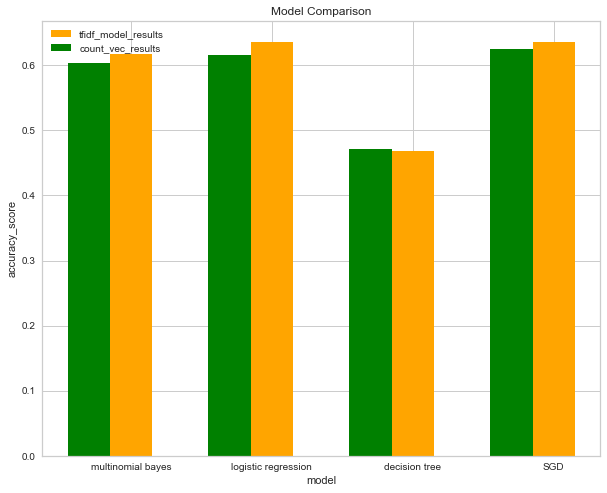

In [165]:
tfidf_model_results = pd.DataFrame(model_resultstfidf.items(), columns=['model', 'accuracy_score'])
count_vec_results = pd.DataFrame(model_results_cvec.items(), columns=['model', 'accuracy_score'])

y1 = tfidf_model_results['accuracy_score']
y2 = count_vec_results['accuracy_score']

fig, ax = plt.subplots(figsize = (10,8))
ind = np.arange(len(tfidf_model_results))

width = 0.3  
plt.bar(ind, y1, width, color = 'orange')
plt.bar(ind - width, y2, width,color = 'green')

plt.title('Model Comparison')
plt.xlabel('model')
plt.ylabel('accuracy_score')
plt.xticks(np.arange(4), ['multinomial bayes', 'logistic regression', 'decision tree', 'SGD'])
plt.legend(['tfidf_model_results', 'count_vec_results'])
fig.savefig('./images/modelcomparisonplot.png')

### Merging the two tables for use in slides

In [166]:
model_scores = pd.merge(tfidf_model_results, count_vec_results, how = 'left', on = 'model')
model_scores = model_scores.rename(columns = {'accuracy_score_x':'tfidf_score', 'accuracy_score_y':'count_vec_score'})
dfi.export(model_scores, './images/model_scores.png')

## Extracting best Parameters in the best model

In [142]:
logreg_tfidf_gs.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}

# Applying Logistic Regression Model Pipeline to the test set

In [143]:
logreg_pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=15)),
                            ('clf', LogisticRegression(C = 1.0, class_weight = 'balanced', multi_class = 'ovr', penalty = 'l2', solver = 'liblinear', random_state = 42))])

logreg_pipeline.fit(X_train, y_train)
y_hat_prob=logreg_pipeline.predict_proba(X_test)
y_hat = logreg_pipeline.predict(X_test)
print('Test Accuracy score:', accuracy_score(y_test, y_hat))
print(classification_report(y_test, y_hat))

Test Accuracy score: 0.6372413793103449
              precision    recall  f1-score   support

           1       0.69      0.68      0.69      1491
           2       0.70      0.65      0.67      1095
           3       0.71      0.80      0.75       292
           4       0.52      0.62      0.56       275
           5       0.34      0.29      0.31       241
           6       0.41      0.48      0.44       231

    accuracy                           0.64      3625
   macro avg       0.56      0.59      0.57      3625
weighted avg       0.64      0.64      0.64      3625



## Logreg Confusion Matrix for Test Set

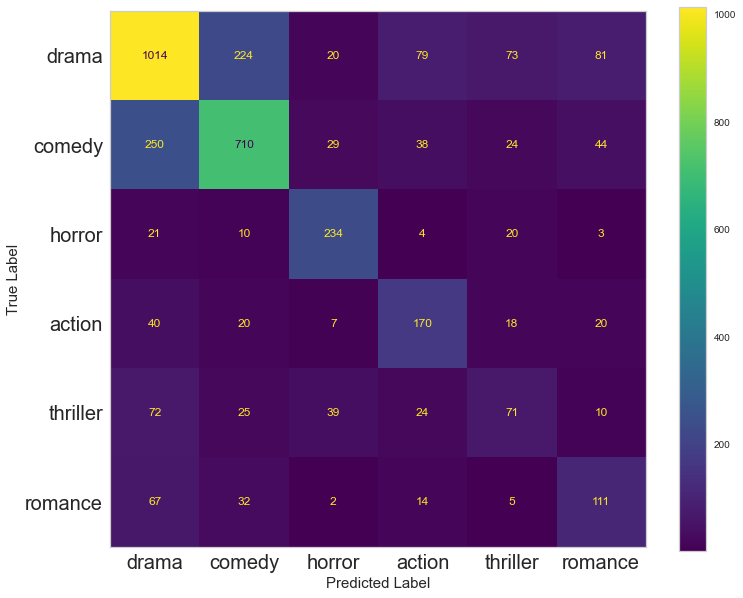

In [151]:
fig, ax = plt.subplots(figsize=(12,10))
plot_confusion_matrix(logreg_pipeline, X_test, y_test, ax = ax, display_labels = ['drama', 'comedy', 'horror', 'action', 'thriller', 'romance'])
plt.grid(None)
plt.xlabel('Predicted Label', size = 15)
plt.ylabel('True Label', size = 15)
plt.xticks(size = 20)
plt.yticks(size = 20)
fig.savefig('./images/confusionmatrix.png')

# Applying SGD Model Pipeline to the test set because the cv scores were so close to those of Logistic regression

There is a small decrease in accuracy score by .02%, however it was still pretty good. I will be sticking to the Logistic Regression becasue that is best overall especially when comparing the confusion matrix

In [163]:
sgd_pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=15)),
                            ('clf', SGDClassifier(alpha = 0.0001, loss = 'log', max_iter = 20, penalty = 'l2', class_weight = 'balanced', random_state = 42))])

sgd_pipeline.fit(X_train, y_train)
y_hat_sgd = sgd_pipeline.predict(X_test)
print('Test Accuracy score:', accuracy_score(y_test, y_hat_sgd))
print(classification_report(y_test, y_hat_sgd))

Test Accuracy score: 0.6353103448275862
              precision    recall  f1-score   support

           1       0.69      0.67      0.68      1491
           2       0.69      0.65      0.67      1095
           3       0.71      0.80      0.75       292
           4       0.52      0.62      0.57       275
           5       0.34      0.32      0.33       241
           6       0.41      0.48      0.44       231

    accuracy                           0.64      3625
   macro avg       0.56      0.59      0.57      3625
weighted avg       0.64      0.64      0.64      3625



 ## SGD Confusion Matrix for Test Set

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'drama'),
  Text(0, 1, 'comedy'),
  Text(0, 2, 'horror'),
  Text(0, 3, 'action'),
  Text(0, 4, 'thriller'),
  Text(0, 5, 'romance')])

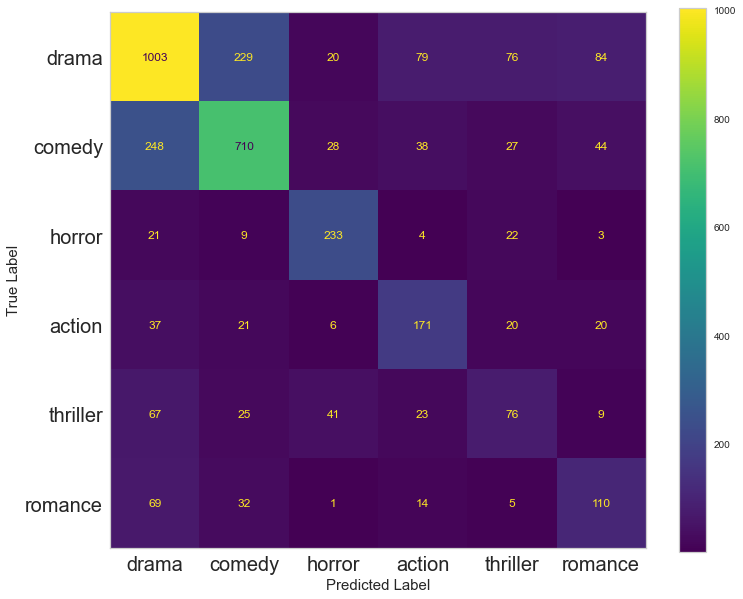

In [164]:
fig, ax = plt.subplots(figsize=(12,10))
plot_confusion_matrix(sgd_pipeline, X_test, y_test, ax = ax, display_labels = ['drama', 'comedy', 'horror', 'action', 'thriller', 'romance'])
plt.grid(None)
plt.xlabel('Predicted Label', size = 15)
plt.ylabel('True Label', size = 15)
plt.xticks(size = 20)
plt.yticks(size = 20)
# fig.savefig('./images/confusionmatrixsgd.png')

### Calculating cosine similarity between thegenres based on the words

In [148]:
genre_plotlist = [['drama', ' '.join(list(set(drama_plotlist)))], ['comedy', ' '.join(list(set(comedy_plotlist)))], 
                  ['horror', ' '.join(list(set(horror_plotlist)))], ['action', ' '.join(list(set(action_plotlist)))],
                 ['thriller', ' '.join(list(set(thriller_plotlist)))], ['romance', ' '.join(list(set(romance_plotlist)))]]
genre_plot_df = pd.DataFrame(genre_plotlist, columns = ['genre_type', 'plot_words'])
genre_plot_df

,genre_type,plot_words
0,drama,senegalese eisen achieve backward kieron posh ...
1,comedy,achieve backward organically posh hedy hookup ...
2,horror,achieve backward journalist telling whittingto...
3,action,voluntarily costume harnam apparition kaname t...
4,thriller,voluntarily costume apparition paneling tel ac...
5,romance,costume apparition knack achieve learning posh...


### The genres have a high cosine similarity with each other (0.46 and above)

In [149]:
from sklearn.metrics.pairwise import cosine_similarity

count_vec = CountVectorizer()
count_matrix = count_vec.fit_transform(genre_plot_df['plot_words'])
cosine_sim = pd.DataFrame(cosine_similarity(count_matrix))
cosine_sim

,0,1,2,3,4,5
0,1.000000,0.575270,0.508835,0.493223,0.515813,0.467859
1,0.575270,1.000000,0.526282,0.501533,0.527712,0.465480
2,0.508835,0.526282,1.000000,0.518732,0.564037,0.481210
3,0.493223,0.501533,0.518732,1.000000,0.552873,0.519102
4,0.515813,0.527712,0.564037,0.552873,1.000000,0.527058
5,0.467859,0.465480,0.481210,0.519102,0.527058,1.000000


# Conclusion

## Results

- Baseline accuracy was 41%
- The tfidf transformed plots performed better during modeling. 
- GridSearchCV helped in narrowing down the best model hyperparameter values.
- The model with the best performance was the Logistic Regression Model on tfidf transformed plots with the following parameters (although SGD ranked pretty highly as well):
   - C = 1.0
   - class_weight = 'balanced'
   - multi_class = 'ovr'
   - penalty = 'l2'
   - solver = 'liblinear'
- When the above model was used on the test set, it produced an accuracy score of ~64% which a significant increase from the baseline
- The confusion matrix confirms what I suspected when looking at the most common words in the genres. 
- Due to the fact that some of the genres had words in common with another genre, false predictions of those genres were mostly as the genres they had common words with.
- The decision tree models performed the least favorably.